In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE


In [4]:
df = pd.read_csv('C:/Users/SHUVAM CHATTERJEE/Downloads/Creditcard_Fraud_Detection/data/creditcard.csv')

In [5]:
if 'Time' in df.columns:
    df = df.drop('Time', axis=1)

In [6]:
df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
X = df.drop('Class', axis=1)
y = df['Class']


In [8]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

In [9]:
smote = SMOTE(sampling_strategy=0.25, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_bal.value_counts())

Before SMOTE: Class
0    170588
1       295
Name: count, dtype: int64
After SMOTE: Class
0    170588
1     42647
Name: count, dtype: int64


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [11]:
lr = LogisticRegression(max_iter = 1000, random_state = 42)
lr.fit(X_train_scaled, y_train_bal)

LogisticRegression(max_iter=1000, random_state=42)

In [12]:
y_val_pred = lr.predict(X_val_scaled)
y_val_proba = lr.predict_proba(X_val_scaled)[:, 1]

In [13]:
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba))

Confusion Matrix:
 [[56564   299]
 [   16    83]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.22      0.84      0.35        99

    accuracy                           0.99     56962
   macro avg       0.61      0.92      0.67     56962
weighted avg       1.00      0.99      1.00     56962

ROC AUC Score: 0.9721910024039704


In [14]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_thresh)

y_val_pred_thresh = (y_val_proba >= best_thresh).astype(int)
print(classification_report(y_val, y_val_pred_thresh))


Best threshold: 0.9998024782204855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.75      0.79        99

    accuracy                           1.00     56962
   macro avg       0.92      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962




[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


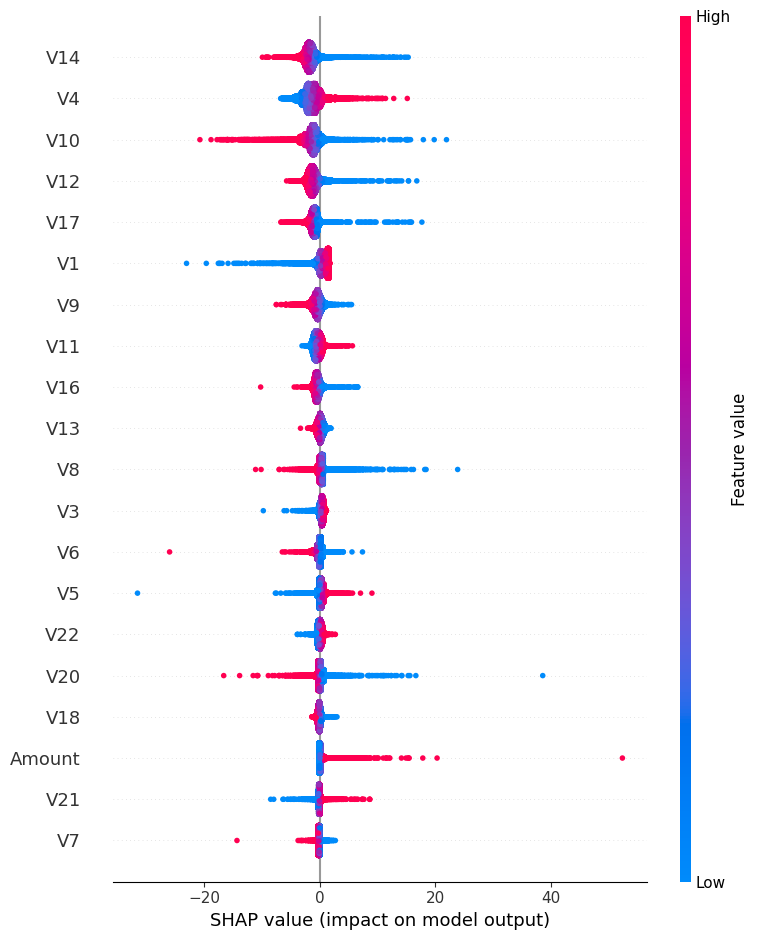

In [15]:
!pip install shap
import shap

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)

explainer = shap.LinearExplainer(lr, X_train_scaled_df)
shap_values = explainer.shap_values(X_val_scaled_df)
shap.summary_plot(shap_values, X_val_scaled_df, plot_type="dot")

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train_bal)
y_pred = rf.predict(X_val_scaled)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.77      0.81        99

    accuracy                           1.00     56962
   macro avg       0.93      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [17]:
from sklearn.metrics import precision_recall_curve

y_val_proba = rf.predict_proba(X_val_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_thresh)

y_pred_thresh = (y_val_proba >= best_thresh).astype(int)
print(classification_report(y_val, y_pred_thresh))


Best threshold: 0.6
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.87      0.76      0.81        99

    accuracy                           1.00     56962
   macro avg       0.94      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [18]:
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=1,  
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)


xgb_model.fit(X_train_bal, y_train_bal)

y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]


print("Classification Report:\n", classification_report(y_val, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_val, y_prob_xgb))


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\SHUVAM CHATTERJEE\Downloads\Creditcard_Fraud_Detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:03:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.78      0.81        99

    accuracy                           1.00     56962
   macro avg       0.93      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56850    13]
 [   22    77]]
ROC AUC: 0.9623083089836515


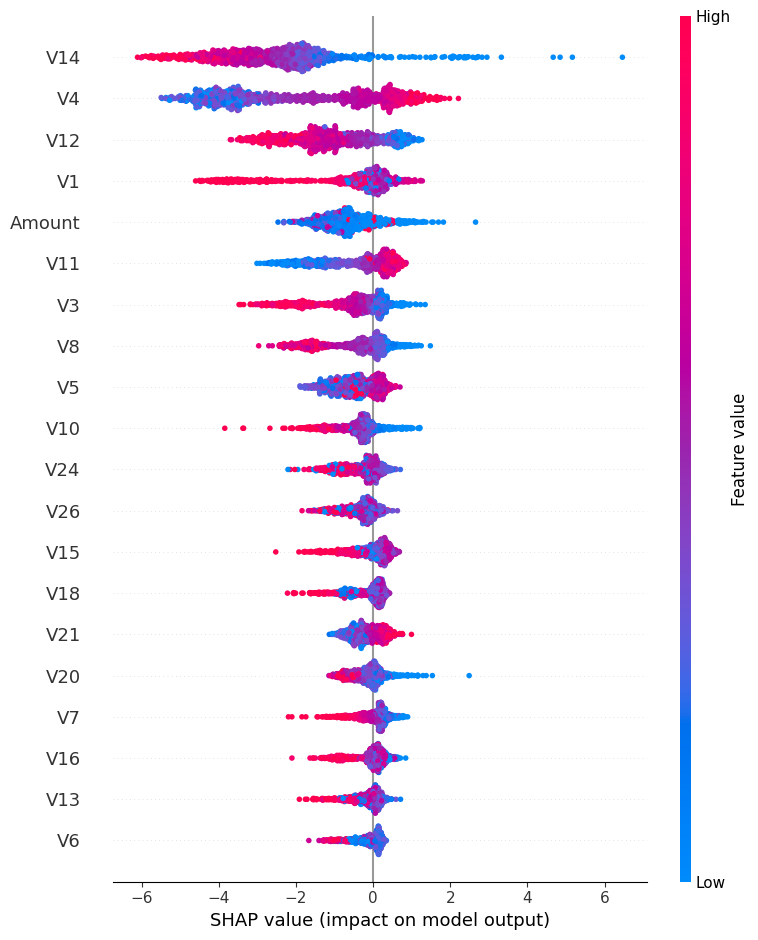

In [19]:
explainer = shap.Explainer(xgb_model)
X_sample = X_val[:1000]  
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="dot")

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [1, 5, 10, 20]  
}

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
search = RandomizedSearchCV(model, params, scoring='recall', n_iter=20, cv=3, n_jobs=-1, verbose=2)
search.fit(X_train_scaled, y_train_bal)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\SHUVAM CHATTERJEE\Downloads\Creditcard_Fraud_Detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:04:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1, 5, 10, 20],
                                        'subsample': [0.7, 1.0]},
                   scoring='recall', verbose=2)

In [21]:
best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = best_model.predict(X_val_scaled)
print(classification_report(y_val, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, best_model.predict_proba(X_val_scaled)[:, 1]))


Best hyperparameters: {'subsample': 0.7, 'scale_pos_weight': 20, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
              precision    recall  f1-score   support

           0     0.9996    0.9991    0.9994     56863
           1     0.6142    0.7879    0.6903        99

    accuracy                         0.9988     56962
   macro avg     0.8069    0.8935    0.8448     56962
weighted avg     0.9990    0.9988    0.9988     56962

Confusion Matrix:
 [[56814    49]
 [   21    78]]
ROC AUC Score: 0.9568656688048911


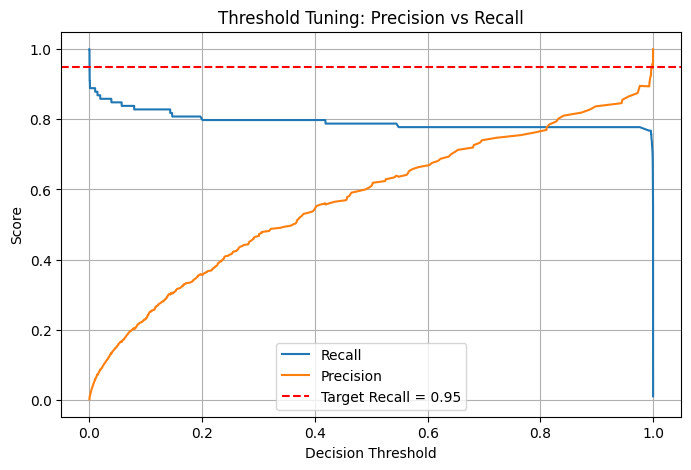

In [33]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
y_scores = best_model.predict_proba(X_val_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.axhline(y=0.95, color='r', linestyle='--', label='Target Recall = 0.95')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.title("Threshold Tuning: Precision vs Recall")
plt.show()


In [28]:
from sklearn.metrics import confusion_matrix
y_probs = best_model.predict_proba(X_val_scaled)[:, 1]

y_thresh_pred = (y_probs >= best_thresh).astype(int)  
cm = confusion_matrix(y_val, y_thresh_pred)


FP = cm[0][1]  # False Positives: predicted fraud, actually not fraud
FN = cm[1][0]  # False Negatives: predicted not fraud, actually fraud

cost_fn = 1000  # Cost of missing a fraud
cost_fp = 10    # Cost of false alarm

total_cost = FP * cost_fp + FN * cost_fn
print("📉 Total Business Cost: $", total_cost)


📉 Total Business Cost: $ 22380


In [29]:
thresholds = np.arange(0.01, 1.0, 0.01)
costs = []


for t in thresholds:
    y_thresh_pred = (y_probs >= t).astype(int)
    cm = confusion_matrix(y_val, y_thresh_pred)
    FP = cm[0][1]
    FN = cm[1][0]
    total_cost = FP * cost_fp + FN * cost_fn
    costs.append(total_cost)

best_thresh_index = np.argmin(costs)
best_thresh = thresholds[best_thresh_index]
print(f"✅ Optimal threshold that minimizes business cost: {best_thresh:.3f}")


✅ Optimal threshold that minimizes business cost: 0.140


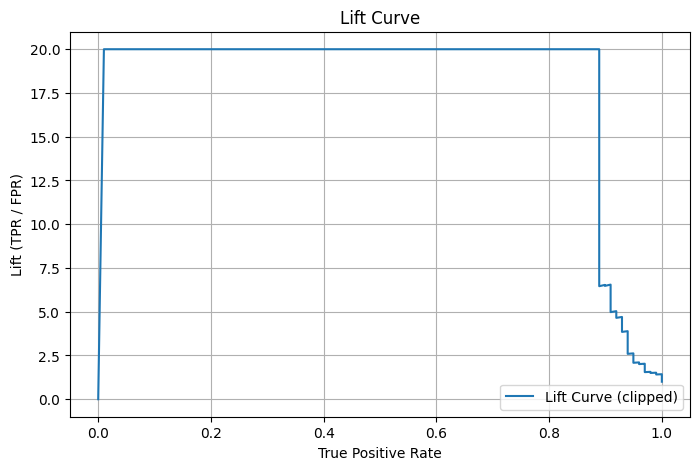

In [30]:
from sklearn.metrics import roc_curve
y_scores = best_model.predict_proba(X_val_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_scores)

epsilon = 1e-10
fpr_safe = np.where(fpr == 0, epsilon, fpr)

lift = tpr / fpr_safe
lift_clipped = np.clip(lift, 0, 20)

plt.figure(figsize=(8, 5))
plt.plot(tpr, lift_clipped, label='Lift Curve (clipped)')
plt.xlabel('True Positive Rate')
plt.ylabel('Lift (TPR / FPR)')
plt.title('Lift Curve')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
print("🔍 Final Model Evaluation Summary")
print("-----------------------------------")
print(f"Optimal Threshold: {best_thresh:.3f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_probs):.4f}")

# Final predictions
y_final_pred = (y_probs >= best_thresh).astype(int)
final_cm = confusion_matrix(y_val, y_final_pred)
final_report = classification_report(y_val, y_final_pred, digits=4)

print("\n📊 Classification Report:")
print(final_report)

print("📉 Confusion Matrix:")
print(final_cm)

FP = final_cm[0][1]
FN = final_cm[1][0]
final_cost = FP * cost_fp + FN * cost_fn
print(f"\n💸 Final Total Business Cost at Optimal Threshold: ${final_cost}")


🔍 Final Model Evaluation Summary
-----------------------------------
Optimal Threshold: 0.140
ROC AUC: 0.9569

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9966    0.9982     56863
           1     0.3004    0.8283    0.4409        99

    accuracy                         0.9963     56962
   macro avg     0.6500    0.9125    0.7195     56962
weighted avg     0.9985    0.9963    0.9972     56962

📉 Confusion Matrix:
[[56672   191]
 [   17    82]]

💸 Final Total Business Cost at Optimal Threshold: $18910


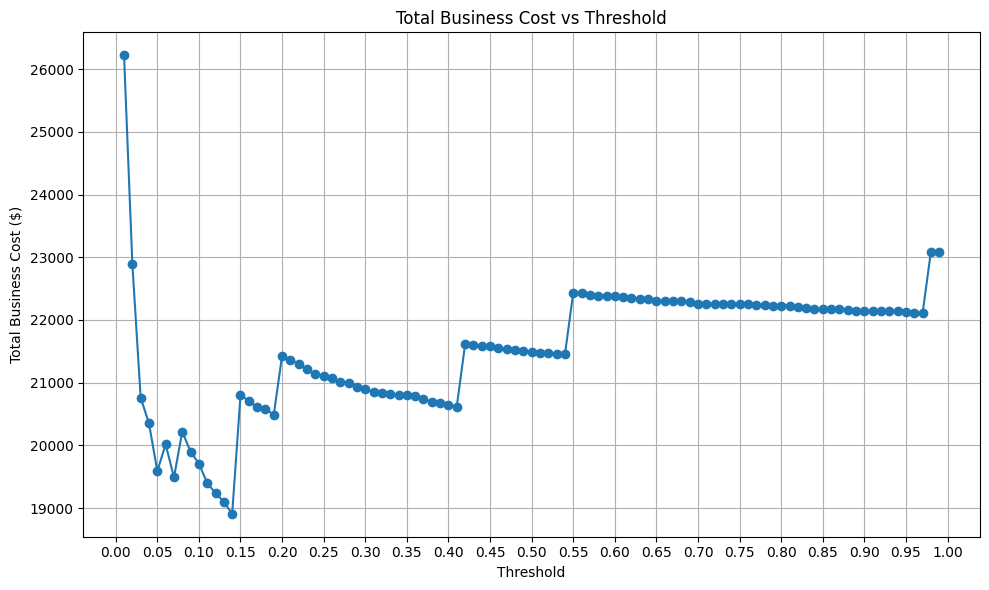

In [32]:
thresholds = np.arange(0.01, 1.0, 0.01)


cost_fn = 1000  # Cost of missing a fraud
cost_fp = 10    # Cost of false alarm

costs = []


for t in thresholds:
    y_thresh_pred = (y_probs >= t).astype(int)
    cm = confusion_matrix(y_val, y_thresh_pred)
    FP = cm[0][1]
    FN = cm[1][0]
    total_cost = FP * cost_fp + FN * cost_fn
    costs.append(total_cost)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o', linestyle='-')
plt.title("Total Business Cost vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost ($)")
plt.grid(True)
plt.xticks(np.arange(0, 1.05, 0.05))
plt.tight_layout()
plt.show()

### 📈 Optimal Threshold Selection: Business-Driven Approach

The chart above shows the **Total Business Cost** across a range of classification thresholds.

- Each threshold represents a different decision boundary for flagging transactions as fraud.
- **False Negatives (missed frauds)** incur a high penalty of **1000**.  
- **False Positives (false alarms)** incur a smaller penalty of **10**.

🔍 **Observation**:
- The minimum business cost of **$18,910** occurs at a threshold of **~0.14**.
- Beyond this threshold, cost rises due to a sharp increase in **missed frauds** (False Negatives).
- Below this threshold, cost increases due to excessive **false positives**.

📌 **Recommendation**:
Set the threshold to **0.14** to balance recall and precision and **minimize overall financial loss** to the business.

---


In [35]:

X_test_scaled = scaler.transform(X_test)

optimal_threshold = best_thresh

y_test_probs = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)


print(classification_report(y_test, y_test_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_probs))


              precision    recall  f1-score   support

           0     0.9998    0.9963    0.9981     56864
           1     0.2939    0.8878    0.4416        98

    accuracy                         0.9961     56962
   macro avg     0.6469    0.9420    0.7198     56962
weighted avg     0.9986    0.9961    0.9971     56962

Confusion Matrix:
 [[56655   209]
 [   11    87]]
ROC AUC: 0.978836364315


In [36]:
import os


root_output_path = os.path.abspath(os.path.join(os.getcwd(), "..", "output"))
print("Full path to root-level output directory:\n", root_output_path)


Full path to root-level output directory:
 C:\Users\SHUVAM CHATTERJEE\Downloads\Creditcard_Fraud_Detection\output


In [38]:
import joblib

root_output_path = "C:/Users/SHUVAM CHATTERJEE/Downloads/Creditcard_Fraud_Detection/output"

joblib.dump(best_model, os.path.join(root_output_path, "fraud_best_model.pkl"))
joblib.dump(scaler, os.path.join(root_output_path, "fraud_scaler.pkl"))
joblib.dump(X_test_scaled, os.path.join(root_output_path, "X_test_scaled.pkl"))
joblib.dump(y_test, os.path.join(root_output_path, "y_test.pkl"))

with open(os.path.join(root_output_path, "optimal_threshold.txt"), "w") as f:
    f.write(str(optimal_threshold))

